In [17]:

import numpy as np 
import pandas as pd 

import os


"""
AUTHOR'S WORDS:


[Machine Predictive Maintenance Classification Dataset]

Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, we present and provide a synthetic 
dataset that reflects real predictive maintenance encountered in the industry to the best of our knowledge.

The dataset consists of 10 000 data points stored as rows with 14 features in columns


UID                     : unique identifier ranging from 1 to 10000

productID               : consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants 
                          and a variant-specific serial number

air temperature [K]     : generated using a random walk process later normalized to a standard deviation of 2 K around 300 K

process temperature [K] : generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

rotational speed [rpm]  : calculated from powepower of 2860 W, overlaid with a normally distributed noise

torque [Nm]             : torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.

tool wear [min]         : The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a 'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.


Important : There are two Targets - Do not make the mistake of using one of them as feature, as it will lead to leakage.

Target       : Failure or Not
Failure Type : Type of Failure

In [18]:
df = pd.read_csv('./predictive_maintenance.csv',index_col='UDI')
df.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
UDI,,,,,,,,,
1,78912314860,789123,298.1,308.6,1551,42.8,0,0,0
2,65432147181,654321,298.2,308.7,1408,46.3,3,0,0
3,65432147182,654321,298.1,308.5,1498,49.4,5,0,0
4,65432147183,654321,298.2,308.6,1433,39.5,7,0,0
5,65432147184,654321,298.2,308.7,1408,40.0,9,0,0


* Product ID is unique for every member of the dataframe, so they contain no usefull data and will be deleted
* The next column (Type) shows the quality of the tool used, which is usefull in predicting the life of the tool

Remaining columns until Target are all usefull data about the working conditions of the tool

* Target column indicates wether the tool has failed (Target==1) or not (Target==0)
* Failure Type column shows the same data as the target column, but in the cases where there was a failure it also mentiones the type of the failure the tool has experienced

So based on the prediction we are going to make (wether we only want to predict the failure or we want to predict the type sa well), we have to use only one of the last two columns in order to stop any data leakage from happening.
The intention of this nptebook is predicting failure, not failure type. Because of this, the failure type column will be deleted later.

In [19]:
df.drop(columns = ['Product ID'],inplace=True)

In [20]:
from sklearn.preprocessing import LabelEncoder
type_enc = LabelEncoder()
df['Type'] = type_enc.fit_transform(df['Type'])
df.isna().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

We have to make sure there are no NA values inside the dataframe as well, since if there are any we have to resolve them.

In [21]:
df[(df['Target']==1)&(df['Failure Type']=='No Failure')]

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
UDI,,,,,,,,


In some cases, the data available in the Target column indicates that the tool has failed, but the Failure Type column indicated that the tool has not had any failure. 

In [22]:
df.drop(df[(df['Target']==1)&(df['Failure Type']=='No Failure')].index,inplace=True)

In [23]:
df.drop(columns = ['Failure Type'],inplace=True)
df.groupby('Target').size()

Target
0    9660
1     339
dtype: int64

It can be seen that the dataset is severly imbalanced. So first we divide the dataframe into training and testing sections and then apply oversampling to the training section of the dataset in order to balance the information used for training the model. This is done after dividing the datasets in order to stop any data leakage from happening and also for the testing dataset of the model to be representative of the real world.

In [24]:
from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(df,stratify=df['Target'],test_size=0.2)

In [25]:
from imblearn.over_sampling import SMOTE

def sm_oversamp(inp_x,inp_y):
    ov_samp = SMOTE(k_neighbors=4,sampling_strategy='minority')
    return ov_samp.fit_resample(inp_x,inp_y)

x_train = train_data.drop(columns=['Target'])
y_train = train_data['Target']

x_train_os,y_train_os = sm_oversamp(x_train,y_train)

In [26]:
from sklearn.preprocessing import MinMaxScaler
feature_scaler = MinMaxScaler()
feature_scaler.fit(x_train_os)
print(x_train_os.head())

   Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0     2                297.6                    308.7                    1408   
1     1                302.6                    311.0                    1506   
2     1                302.0                    310.5                    1567   
3     1                298.7                    308.4                    1373   
4     1                298.4                    309.5                    1376   

   Torque [Nm]  Tool wear [min]  
0         51.5                4  
1         37.2               95  
2         36.1              124  
3         46.9               60  
4         50.4              202  


In [27]:
train_features_scaled = pd.DataFrame(feature_scaler.transform(x_train_os))
test_features_scaled = pd.DataFrame(feature_scaler.transform(test_data.drop(columns=['Target'])))
print(x_train_os)
train_features_scaled

       Type  Air temperature [K]  Process temperature [K]  \
0         2           297.600000               308.700000   
1         1           302.600000               311.000000   
2         1           302.000000               310.500000   
3         1           298.700000               308.400000   
4         1           298.400000               309.500000   
...     ...                  ...                      ...   
15451     1           301.388183               310.303939   
15452     1           301.706380               310.155316   
15453     1           299.667147               308.918194   
15454     1           302.440754               311.029024   
15455     1           303.007385               311.135795   

       Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  
0                        1408    51.500000                4  
1                        1506    37.200000               95  
2                        1567    36.100000              124  
3                  

,0,1,2,3,4,5
0,1.0,0.250000,0.370370,0.139697,0.655220,0.015810
1,0.5,0.793478,0.654321,0.196740,0.458791,0.375494
2,0.5,0.728261,0.592593,0.232247,0.443681,0.490119
3,0.5,0.369565,0.333333,0.119325,0.592033,0.237154
4,0.5,0.336957,0.469136,0.121071,0.640110,0.798419
...,...,...,...,...,...,...
15451,0.5,0.661759,0.568388,0.083236,0.851910,0.173913
15452,0.5,0.696346,0.550039,0.107683,0.759294,0.430830
15453,0.5,0.474690,0.397308,0.086729,0.822476,0.747036
15454,0.5,0.776169,0.657904,0.121653,0.633378,0.130435


In [28]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
xgb_model = XGBClassifier()

params = {
    'n_estimators': [50, 75, 100, 150, 200],
    'max_depth': [2, 5, 8, 10, 12],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=params,
    n_iter=10,
    scoring='recall',
    cv=5
)

random_search.fit(train_features_scaled,y_train_os)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': [2, 5, 8, 10, 12],
                                        'n_estimators': [50, 75, 100, 150, 200],
                                        'subsample': [0.8, 0.9, 1.0]},
                   scoring='recall')

In [29]:
best_model = random_search.best_estimator_
random_search.best_params_

{'subsample': 1.0,
 'n_estimators': 200,
 'max_depth': 12,
 'learning_rate': 0.1,
 'colsample_bytree': 0.9}

In [30]:
y_pred = best_model.predict(test_features_scaled)

from sklearn.metrics import classification_report
print(classification_report(test_data['Target'],y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1932
           1       0.49      0.72      0.59        68

    accuracy                           0.97      2000
   macro avg       0.74      0.85      0.78      2000
weighted avg       0.97      0.97      0.97      2000



In [31]:
import pickle
with (open('model.pkl','wb')) as file:
    pickle.dump(best_model,file)

In [32]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

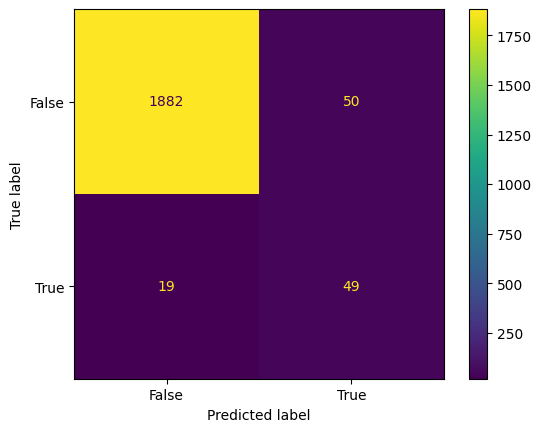

In [33]:
confusion_matrix = metrics.confusion_matrix(test_data['Target'],y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()